In [10]:
import tensorflow as tf

# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# -----------------------------
# Cell 1: Imports & Config
# -----------------------------
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt
import cv2


In [12]:
# Paths to preprocessed images
BASE_DIR = r"C:\Users\ayush\Downloads\alignimages\preprocessed_ordered"
HR_DIR = os.path.join(BASE_DIR, "HR")
LR_DIR = os.path.join(BASE_DIR, "LR")
IR_DIR = os.path.join(BASE_DIR, "IR")

IMG_SIZE = (256, 256)
BATCH_SIZE = 1   # small for notebook
EPOCHS = 2       # few epochs for testing
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE

OUT_DIR = r"C:\Users\ayush\Downloads\alignimages\notebook_fused_samples"
os.makedirs(OUT_DIR, exist_ok=True)



In [13]:
# Cell 2: Load dataset
# -----------------------------
def load_images(folder, single_channel=False):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.npy')])
    imgs = []
    for f in files:
        img = np.load(os.path.join(folder, f)).astype(np.float32)
        if single_channel and img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        imgs.append(img)
    return np.array(imgs, dtype=np.float32)

HR_imgs = load_images(HR_DIR)
LR_imgs = load_images(LR_DIR)
IR_imgs = load_images(IR_DIR, single_channel=True)

dataset = tf.data.Dataset.from_tensor_slices((HR_imgs, LR_imgs, IR_imgs))
dataset = dataset.shuffle(buffer_size=10).batch(BATCH_SIZE).prefetch(AUTOTUNE)
print(f"Loaded {len(HR_imgs)} HR, {len(LR_imgs)} LR, {len(IR_imgs)} IR images")



Loaded 220 HR, 220 LR, 220 IR images


In [14]:
# Cell 3: Model components
# -----------------------------
def build_encoder(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    return Model(inp, x)

def build_decoder(input_shape, out_channels=3):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(out_channels, 1, padding='same', activation='sigmoid')(x)
    return Model(inp, x)

def attention_block(x):
    # Channel Attention
    avg_pool = tf.reduce_mean(x, axis=[1,2], keepdims=True)
    max_pool = tf.reduce_max(x, axis=[1,2], keepdims=True)
    shared_mlp = layers.Dense(x.shape[-1]//8, activation='relu')
    out_avg = shared_mlp(avg_pool)
    out_max = shared_mlp(max_pool)
    channel_att = tf.nn.sigmoid(out_avg + out_max)
    x = x * channel_att

    # Spatial Attention
    avg_pool_sp = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_pool_sp = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = tf.concat([avg_pool_sp, max_pool_sp], axis=-1)
    spatial_att = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    x = x * spatial_att
    return x



In [15]:
# -----------------------------
# Cell 4: Build DeepFuse + Corrected Attention
# -----------------------------
def attention_block(x):
    """Lightweight Channel + Spatial Attention Block"""
    channels = x.shape[-1]
    
    # --- Channel Attention ---
    avg_pool = tf.reduce_mean(x, axis=[1,2], keepdims=True)
    max_pool = tf.reduce_max(x, axis=[1,2], keepdims=True)
    
    # MLP: reduce channels then restore
    shared_mlp_1 = layers.Dense(channels//8, activation='relu')
    shared_mlp_2 = layers.Dense(channels)  # restore channels
    
    out_avg = shared_mlp_2(shared_mlp_1(avg_pool))
    out_max = shared_mlp_2(shared_mlp_1(max_pool))
    
    channel_att = tf.nn.sigmoid(out_avg + out_max)
    x = x * channel_att  # now shapes match
    
    # --- Spatial Attention ---
    avg_pool_sp = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_pool_sp = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = tf.concat([avg_pool_sp, max_pool_sp], axis=-1)
    spatial_att = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    x = x * spatial_att
    
    return x

# --- Encoders and Decoder ---
encoder_rgb = build_encoder((IMG_SIZE[1], IMG_SIZE[0], 3))
encoder_ir = build_encoder((IMG_SIZE[1], IMG_SIZE[0], 1))
decoder = build_decoder((IMG_SIZE[1], IMG_SIZE[0], 64))

# --- Inputs ---
inp_hr = Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 3))
inp_lr = Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 3))
inp_ir = Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 1))

# --- Encode ---
f_hr = encoder_rgb(inp_hr)
f_lr = encoder_rgb(inp_lr)
f_ir = encoder_ir(inp_ir)

# --- Apply Attention ---
f_hr_att = attention_block(f_hr)
f_lr_att = attention_block(f_lr)
f_ir_att = attention_block(f_ir)

# --- Fusion ---
f_fused = layers.Add()([f_hr_att, f_lr_att, f_ir_att])

# --- Decode ---
out = decoder(f_fused)

# --- Model ---
model = Model(inputs=[inp_hr, inp_lr, inp_ir], outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss='mse')
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                          


Epoch 1/2
  Step 0, Loss: 0.065141
  Step 10, Loss: 0.041150
  Step 20, Loss: 0.013210
  Step 30, Loss: 0.031353
  Step 40, Loss: 0.020105
  Step 50, Loss: 0.026931
  Step 60, Loss: 0.020993
  Step 70, Loss: 0.014637
  Step 80, Loss: 0.061490
  Step 90, Loss: 0.022322
  Step 100, Loss: 0.035407
  Step 110, Loss: 0.049027
  Step 120, Loss: 0.019479
  Step 130, Loss: 0.028770
  Step 140, Loss: 0.050560
  Step 150, Loss: 0.021082
  Step 160, Loss: 0.019961
  Step 170, Loss: 0.020878
  Step 180, Loss: 0.019767
  Step 190, Loss: 0.030394
  Step 200, Loss: 0.017176
  Step 210, Loss: 0.017593
Epoch 1 mean loss: 0.030484


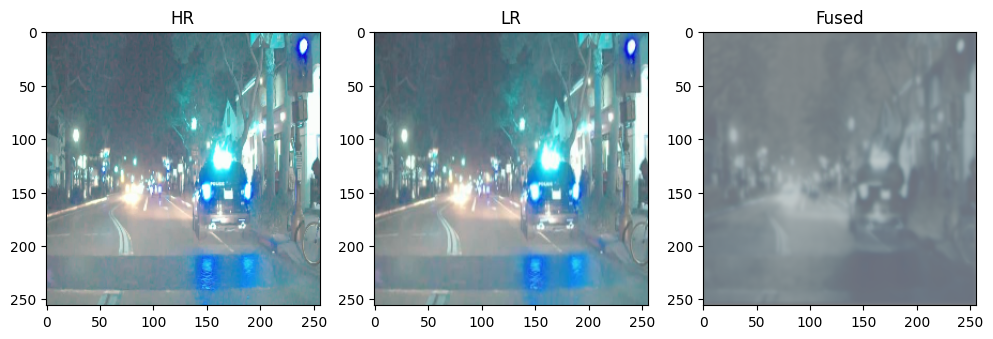


Epoch 2/2
  Step 0, Loss: 0.019022
  Step 10, Loss: 0.011928
  Step 20, Loss: 0.008106
  Step 30, Loss: 0.011913
  Step 40, Loss: 0.007646
  Step 50, Loss: 0.006264
  Step 60, Loss: 0.007214
  Step 70, Loss: 0.006137
  Step 80, Loss: 0.023621
  Step 90, Loss: 0.009823
  Step 100, Loss: 0.013572
  Step 110, Loss: 0.008184
  Step 120, Loss: 0.003247
  Step 130, Loss: 0.004626
  Step 140, Loss: 0.007101
  Step 150, Loss: 0.010667
  Step 160, Loss: 0.004969
  Step 170, Loss: 0.005222
  Step 180, Loss: 0.003695
  Step 190, Loss: 0.009150
  Step 200, Loss: 0.004175
  Step 210, Loss: 0.007443
Epoch 2 mean loss: 0.008101


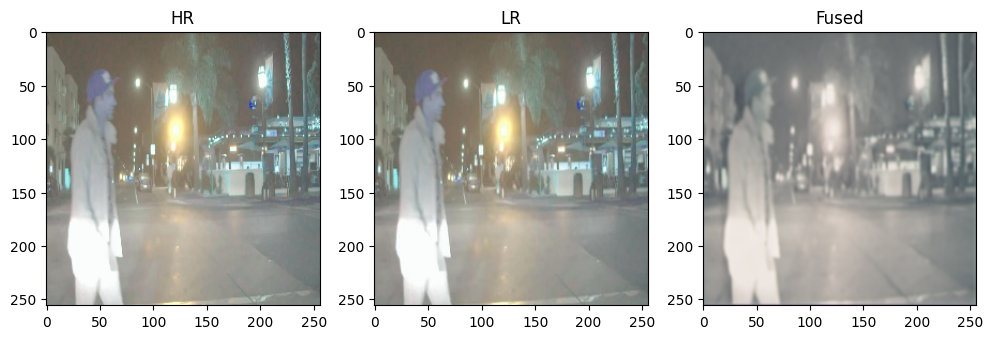

In [16]:
# Cell 5: Training & Save Samples
# -----------------------------
for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    epoch_loss = []
    for step, (hr, lr, ir) in enumerate(dataset):
        with tf.GradientTape() as tape:
            fused = model([hr, lr, ir], training=True)
            loss = tf.keras.losses.MSE(hr, fused)
        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss.append(tf.reduce_mean(loss).numpy())
        if step % 10 == 0:
            print(f"  Step {step}, Loss: {tf.reduce_mean(loss).numpy():.6f}")

    print(f"Epoch {epoch} mean loss: {np.mean(epoch_loss):.6f}")

    # Save first 3 fused images per epoch
    fused_pred = fused.numpy()
    for k in range(min(3, fused_pred.shape[0])):
        out_img = (fused_pred[k]*255.0).astype(np.uint8)
        fname = os.path.join(OUT_DIR, f"epoch{epoch:03d}_sample{k+1}.png")
        cv2.imwrite(fname, cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))

    # Inline visualization of first fused image
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(hr[0])
    plt.title("HR")
    plt.subplot(1,3,2)
    plt.imshow(lr[0])
    plt.title("LR")
    plt.subplot(1,3,3)
    plt.imshow(fused_pred[0])
    plt.title("Fused")
    plt.show()
